## Pontificia Universidad Javeriana

Autor: Diego Alejandro Jara Rojas.

Fecha de Inicio: 28 - 07 - 2025

Fecha actual: 17 - 10 - 2025

### **Trabajo en Cluster HPC**

## Problemática
Se tiene que el tratamiento del agua debe ser indispensable para garantizar la pureza y la calidad. Uno de los elementos significativos es aplicar los conceptos de los procesamientos de Datos en Alto Volúmen para solucionar este tipo de problemas que afectan la salud pública. El presente ejemplo tiene como propósito tener en cuenta una metodología para aplicar el PAVD para solucionar o diagnosticar la calidad del agua en la INDIA.

## **Objetivo**
Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLlib PySpark, con el fin de explorar y aplicar técnicas de IA en entornos de procesamiento con alto volumen de datos.

## **Metodología**
1. Importación de los datos desde el cluster en la red de la javeriana (Datos en diferentes formatos)
2. Preproceamiento y limpieza de valores nulos, cambio de datos, EDA, medidas estadísticas.
3. Entrenamiento de modelos: RL (MLlib), tensores(KERAS); la idea es prececir la calidad del agua en la India.
4. Evaluación de los modelos: medidas de rendimiento tales como: precisión (precision), exactitud (accuracy), recall, F1 Score, entre otras.
5. Se tiene como referencia: https://www.intechopen.com/chapters/69568


In [2]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install geopandas
#!pip install findspark
#!pip3 install adjustText
#!pip3 install -U mapclassify
#!pip3 install keras
#!pip3 install tensorflow


In [3]:
#import sys
#!{sys.executable} -m pip install adjustText
#!{sys.executable} -m pip intall "mapclassify >= 2.4.0"

#from adjustText impory adjust_text #Para evitar que se supermonten las etiquetas
#from keras import keras #Para evitar que se supermonten las etiquetas


In [4]:
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [5]:
!which python

~/miniconda3/bin/python


In [6]:
import os

os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#Bibliotecas especializadas
from pylab import *

In [8]:
#Bibliotecas de Contexto PySpark

#Busqueda e inicializacion para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession


In [9]:
### Se crea una sesión para jacer el contexto de procesmaiento desde mi Cuota del Cluster HPC
from pyspark import SparkConf
## Configuracion de la cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

## Se levanta la configuración de mi cuota
configura.setAppName("HPC_Jara")

spark09 = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark09.sparkContext, sparkSession=spark09)

contextoSpark09 = spark09.sparkContext.getOrCreate()

print("Sesion Cluster HPC: Jara 25_08_2025")
spark09

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 22:11:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesion Cluster HPC: Jara 25_08_2025


# 2.- Carga de Datos desde el IDRIVE

In [10]:
### Como estoy en un servidor que no es mio, y ni siquiera lo he realizado ni IMPLEMENTADO
### Requiero saber que configuración de hardware me han dado a mi cuota de sesión
### Adicional como cientifico que soy, requiero tambien como hacer un cluster para saber todo eso de implementación de un cluster,

cantCPUS = spark09._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion Spark09: {cantCPUS}" )
print(spark09.sparkContext.getConf().getAll())


Cantidad de CPU's en mi sesion Spark09: 1
[('spark.driver.port', '42581'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.app.id', 'local-1760757

### Acceso al Cluster de Almacenamiento 

In [11]:
## Se carga el CSV de Water Quality como OBJETO DATAFRAME PySpark

### Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV
df00 = spark09.read.csv("/almacen/calidadAgua/waterquality.csv", header = True, inferSchema=True)

df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# Seccion de Colab

## **3. - Análisis y Preparación de Datos**
Se presentan datos (csv) con los diferentes parámetros de los rios de la India. Cada parámetro es el promedio de los valores medidos en un periodo de tiempo. Los datos han sido extraidos de la web oficial de la India (RiverIndia)

- Tipos de datos: coherencia de tipo de datos, transformación.
- Columnas: conocimiento de las columnas, eliminación.
- Análisis de taso nulos o imposibles: conocimiento.

In [12]:
## Conocimiento de las columnas
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

- STATION CODE: Código de estación de medida.
- LOCATIONS: ubicaciones de los rios.
- STATE: Estado de la India.
- TEMP: Temperatura del agua en °C.
- DO: Oxígeno Disuelto (mg/L). Concentraciones altas de oxigeno representa mejor calidad del agua.
- pH: Logaritmo negativo de la concentración de hidrógeno.
Número adimensional para indicar la acidez del agua.
- CONDUCTIVITY: Mide la habilidad de una solución de conducir corriente. Agua puera NO es conductora de corriente.
- BOD: Bacterias y otros microorganismos que utilizan sustancias organicas como alimento: Demanda Bioquímica de oxígeno. Mayor cantidad de material orgánico mayor BOD.
- NITRATE_N_NITRITE_N: Nitratos/Nitritos "nitrógeno". Altas concentraciones Nitrógeno en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L).
- FECAL_COLIFORM: Promedio de bacterias coliformes: excreciones.
- TOTAL_COLIFORM: Se eliminará pues no aporta al estudio.

**Se presenta las estadísticas de los datos a continuación:**

In [13]:
for valor in df00.columns:
  df00.describe(valor).show()

+-------+-----------------+
|summary|     STATION CODE|
+-------+-----------------+
|  count|              534|
|   mean|2052.516853932584|
| stddev|755.2178560086894|
|    min|               11|
|    max|             3330|
+-------+-----------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                534|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           534|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+------------------+
|summary|              TEMP|
+-------+------------------+
|  count|               534|
|   mean|25.241398865784515|
| stddev|3.4480130875026624|
|    min|              10.5|
|    max|                NA|
+-------+---------

## **Visualización de datos** ##

In [14]:
#Cantidad de valores Nulos o Imposibles
df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



- Se observa que no hay datos nulos o imposibles
- Se procede a Graficar cada una de las dimensiones

In [15]:
#Se crea una vista para ser usada en las visualizaciones

df00.createOrReplaceTempView("df00_sql")

In [16]:
df01 = spark09.sql('''Select * from df00_sql where TEMP is not null and
                  DO is not null and
                  pH is not null and
                  CONDUCTIVITY is not null and
                  BOD is not null and
                  NITRATE_N_NITRITE_N is not null and
                  FECAL_COLIFORM is not null''')

In [17]:
#Se verifica cantidad de valores Nulos o Imposibles
df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+--------------+



#**Tratamiento de datos**

In [18]:
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

In [19]:
#Convertir en float
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'string')]

In [20]:
## Se elimina la columna TOTAL_COLIfORM
df01 = df00.drop('TOTAL_COLIFORM')
df01.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

## **Creación de Tablas para Visualizar los Datos**
- Se hace uso de la función LAMBDA para hacer el tratamiento/limpieza de los datos.

In [21]:
df01.createOrReplaceTempView("df01_sql")

###Se crea una consulta por cada parámetro
do_parametro = spark09.sql("Select DO from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
do_parametro = do_parametro.rdd.map(lambda fila: fila.DO).collect()

###Se crea una consulta por cada parametro PH
ph_parametro = spark09.sql("Select pH from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
ph_parametro = ph_parametro.rdd.map(lambda fila: fila.pH).collect()

###Se crea una consulta por cada parametro COND
COND_parametro = spark09.sql("Select CONDUCTIVITY from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
COND_parametro = COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

###Se crea una consulta por cada parametro BOD
BOD_parametro = spark09.sql("Select BOD from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()

###Se crea una consulta por cada parametro NN
NN_parametro = spark09.sql("Select NITRATE_N_NITRITE_N from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
NN_parametro = NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()

###Se crea una consulta por cada parametro FC
FC_parametro = spark09.sql("Select FECAL_COLIFORM from df01_sql")
##Se hace una consulta para crear el vector de la tabla por cada parámetro
FC_parametro = FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()


In [22]:
#Se crea una funcion general para la creacion de graficas que comparan dos parametros
def comparar_parametros(x_values, y1, y2, label1, label2, y1_label, y2_label):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="whitegrid", context="talk")
    fig, ax1 = plt.subplots(figsize=(13, 7))

    color1, color2 = sns.color_palette("Set2", 2)

    ax1.plot(x_values, y1, color=color1, label=label1, linewidth=2)
    ax1.set_xlabel("Índice de muestra")
    ax1.set_ylabel(y1_label, color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.plot(x_values, y2, color=color2, label=label2, linewidth=2, linestyle="--")
    ax2.set_ylabel(y2_label, color=color2)
    ax2.tick_params(axis="y", labelcolor=color2)

    plt.title(f"Comparación de {label1} vs {label2}", fontsize=16, pad=15)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best", frameon=True)
    plt.tight_layout()
    plt.show()


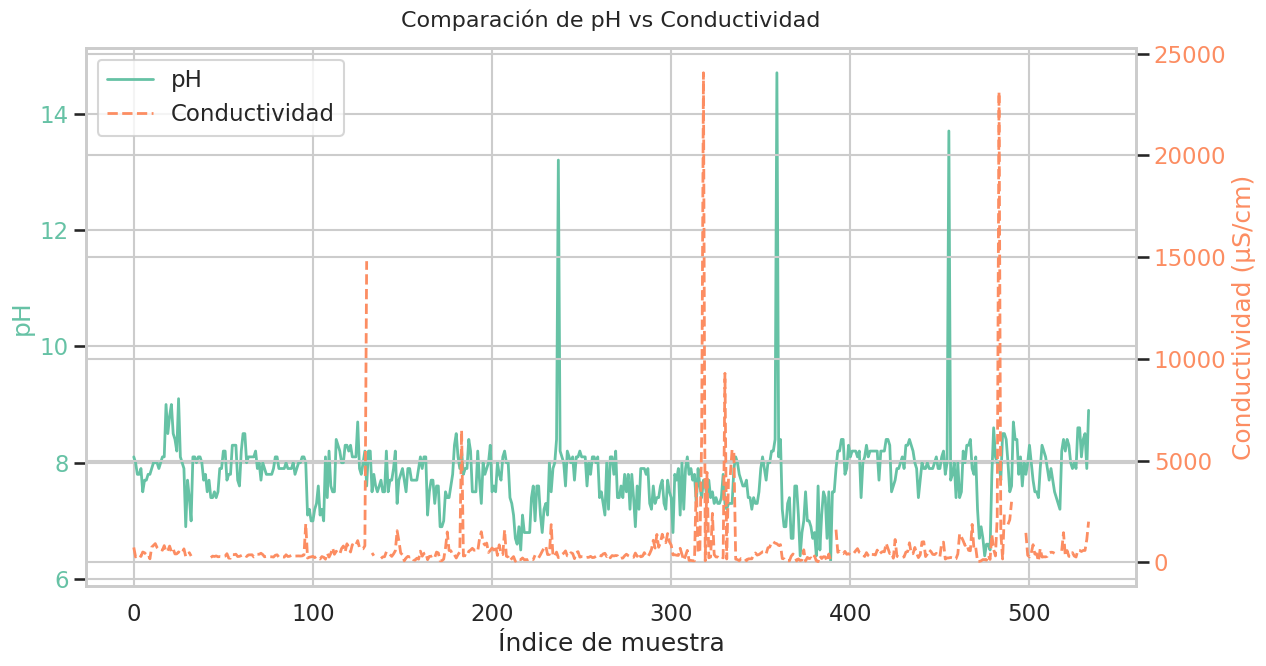

In [23]:
# Realizamos una gráfica de comparación entre los parámetros de Conductividad y Ph del agua

comparar_parametros(
    range(len(ph_parametro)),
    ph_parametro, COND_parametro,
    "pH", "Conductividad",
    "pH", "Conductividad (µS/cm)"
)


**Observación de la gráfica:** En general, el agua muestra un pH estable y adecuado para condiciones naturales (6.5–8.5), mientras que la conductividad varía fuertemente.

**Conclusión de la comparación:** No se observa una correlación fuerte entre el pH y la conductividad, sin embargo se puede pensar que la variación en conductividad puede indicar posibles zonas puntuales de alta concentración de sales o quimicos que aumentan conductividad del agua.

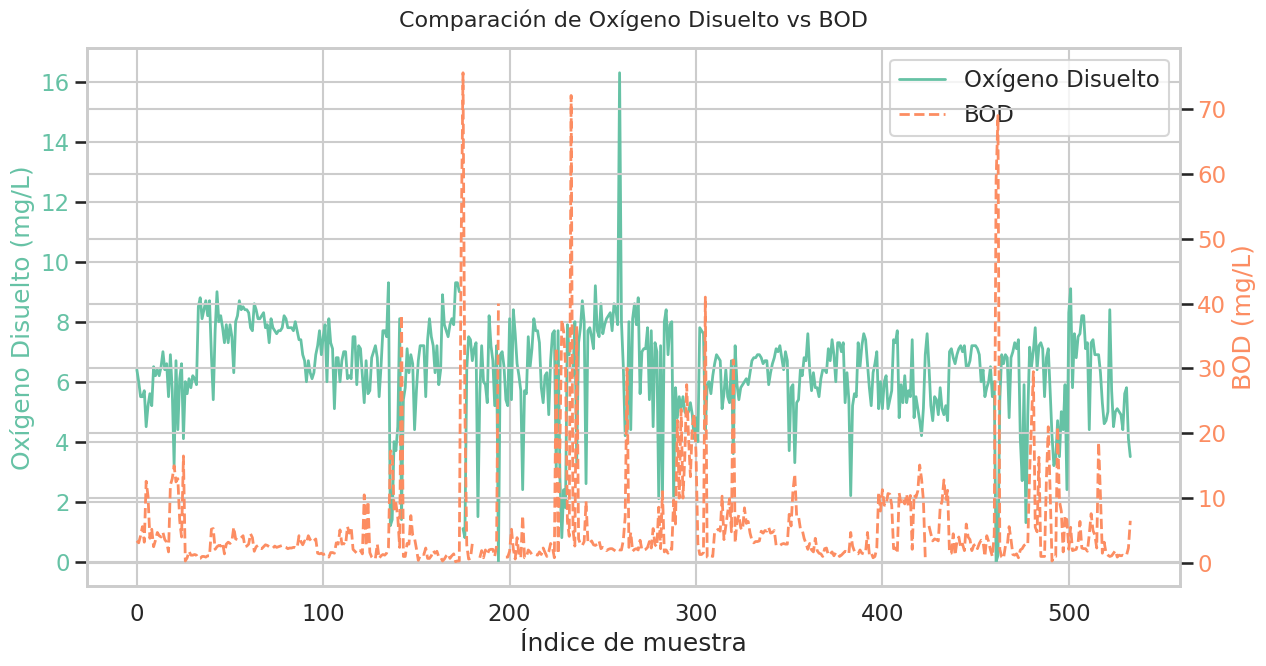

In [24]:
# Realizamos una gráfica de comparación entre los parámetros de Oxígeno Disutelto y materia organica
comparar_parametros(range(len(do_parametro)), do_parametro, BOD_parametro,
                    "Oxígeno Disuelto", "BOD",
                    "Oxígeno Disuelto (mg/L)", "BOD (mg/L)")

**Observación de la gráfica:** Se aprecia que, en general, el Oxígeno Disuelto (DO) presenta variaciones inversas respecto a la demanda bioquímica de oxígeno (BOD). A medida que el BOD aumenta, el DO tiende a disminuir.

**Conclusión de la comparación:** Ambos parámetros tienen una relación inversa, cuando la materia organica aumenta (BOD) el oxígeno (DO) disminuye. El oxígeno disminuye porque la materia organica lo consume.

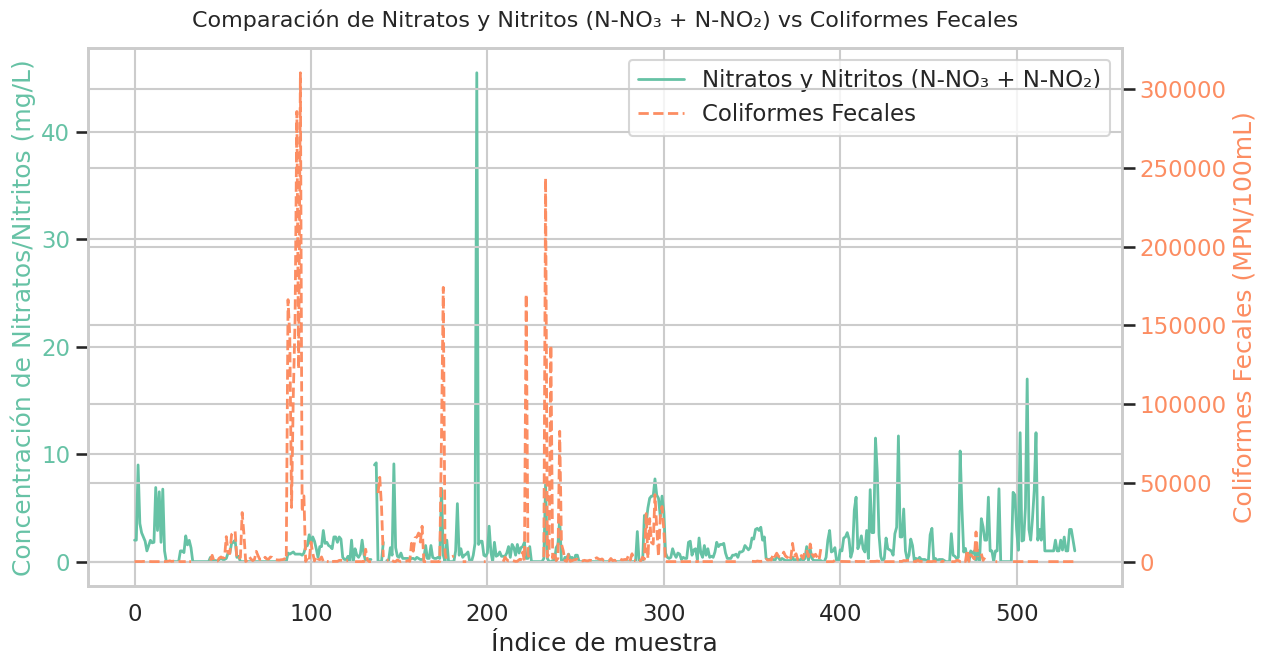

In [25]:
# Realizamos una gráfica de comparación entre los parámetros de Nitritos y Nitratos y Coliformes Fecales

comparar_parametros(
    range(len(NN_parametro)),
    NN_parametro, FC_parametro,
    "Nitratos y Nitritos (N-NO₃ + N-NO₂)", "Coliformes Fecales",
    "Concentración de Nitratos/Nitritos (mg/L)", "Coliformes Fecales (MPN/100mL)"
)

**Observación de la gráfica:** Se observa que las concentraciones de Nitratos y Nitritos se mantienen bajas en la mayoría de las muestras. Por otro lado, los Coliformes Fecales muestran bastantes  picos muy altos

**Conclusión de la comparación:** No se evidencia una correlación directa entre los niveles de Nitratos/Nitritos y los Coliformes Fecales, lo que indica que las fuentes de contaminación química y biológica son distintas o no ocurren simultáneamente.

In [26]:
#Se requiere hacer una función definida por el usuario: que permita definir el rango de la calidad del auga según el PH.
# Se crea la columna para los rangos del parámetro

df02 = df01.withColumn("qrPH", F.when((df01.pH>=7) & (df01.pH<=8.5), 100).
                                when(((df01.pH>=6) & (df01.pH<6.9)) | ((df01.pH>=8.5) & (df01.pH<8.6)),80).
                                when(((df01.pH>=6.7) & (df01.pH<6.8)) | ((df01.pH>=8.6) & (df01.pH<8.8)),60).
                                when(((df01.pH>=6.5) & (df01.pH<6.7)) | ((df01.pH>=8.8) & (df01.pH<9.0)),40).otherwise(0))

In [27]:
### Función definida por el usuario para definir el rando de la calidad del agua según DO
df02 = df02.withColumn("qrDO", F.when((df01.DO>=6), 100).
                                when((df01.DO>=5.7) & (df01.DO<6.0), 80).
                                when((df01.DO>=4.1) & (df01.DO<5.0), 60).
                                when((df01.DO>=3.0) & (df01.DO<6.0), 40).otherwise(0))


In [28]:
### Función definida por el usuario para definir el rando de la calidad del agua según Conductividad
df02 = df02.withColumn("qrCOND", F.when(((df01.CONDUCTIVITY>=0.0) & (df01.CONDUCTIVITY<=75.0)), 100).
                                when((df01.CONDUCTIVITY>=75.0) & (df01.CONDUCTIVITY<150.0), 80).
                                when((df01.CONDUCTIVITY>=150.0) & (df01.CONDUCTIVITY<225.0), 60).
                                when((df01.CONDUCTIVITY>=225.0) & (df01.CONDUCTIVITY<300.0), 40).otherwise(0))


In [29]:
### Función definida por el usuario para definir el rando de la calidad del agua según BOD
df02 = df02.withColumn("qrBOD", F.when(((df01.BOD>=0.0) & (df01.BOD<=3.0)), 100).
                                when((df01.BOD>=8.0) & (df01.BOD<6.0), 80).
                                when((df01.BOD>=6.0) & (df01.BOD<80.0), 60).
                                when((df01.BOD>=80.0) & (df01.BOD<125.0), 40).otherwise(0))

In [30]:
### Función definida por el usuario para definir el rando de la calidad del agua según NN
    ### 100: Agua Dulce
    ### 80: Agua Moderada
    ### 60: Agua Dura
    ### 40: Agua muy Dura

df02 = df02.withColumn("qrNN", F.when(((df01.NITRATE_N_NITRITE_N>=0.0) & (df01.NITRATE_N_NITRITE_N<=20.0)), 100).
                                when((df01.NITRATE_N_NITRITE_N>=20.0) & (df01.NITRATE_N_NITRITE_N<50.0), 80).
                                when((df01.NITRATE_N_NITRITE_N>=50.0) & (df01.NITRATE_N_NITRITE_N<100.0), 60).
                                when((df01.NITRATE_N_NITRITE_N>=100.0) & (df01.NITRATE_N_NITRITE_N<200.0), 40).otherwise(0))

In [31]:
### Función definida por el usuario para definir el rando de la calidad del agua según el Material Fecal
    ### 100: Agua Dulce
    ### 80: Agua Moderada
    ### 60: Agua Dura
    ### 40: Agua muy Dura

df02 = df02.withColumn("qrFecal", F.when(((df01.FECAL_COLIFORM>=0.0) & (df01.FECAL_COLIFORM<=5.0)), 100).
                                when((df01.FECAL_COLIFORM>=5.0) & (df01.FECAL_COLIFORM<50.0), 80).
                                when((df01.FECAL_COLIFORM>=50.0) & (df01.FECAL_COLIFORM<500.0), 60).
                                when((df01.FECAL_COLIFORM>=500.0) & (df01.FECAL_COLIFORM<1000.0), 40).otherwise(0))

## El objeto dataframe df02, contiene hasta ahora todos los calculo y registros sobre los rangos de calidad del agua

In [32]:
#A continuación se hace una inspección en general del df02
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  40|     0|    0| 100|     60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|  

## **Creación de columnas que contengan el indice de calidad según la referencia bibliográfica**

In [33]:
### Se crea un nuevo objeto dataframe con las nuevas columnas de Indice de Calidad
df03 = df02.withColumn("wpH", F.round(df02.qrPH*0.165,3))
df03 = df03.withColumn("wDO", F.round(df03.qrDO*0.281,3))
df03 = df03.withColumn("wCOND", F.round(df03.qrCOND*0.234,3))
df03 = df03.withColumn("wBOD", F.round(df03.qrBOD*0.009,3))
df03 = df03.withColumn("wNN", F.round(df03.qrNN*0.028,3))
df03 = df03.withColumn("wFecal", F.round(df03.qrFecal*0.281,3))

In [34]:
df03.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0|4.2|             

In [35]:
df03.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFecal',
 'wpH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFecal']

In [36]:
# Rango para el parámetro PH
df04 = (df03.withColumn)

### **Calculo de Índice de Calidad del Agua**

- Se crea la columna WQI: repreenta el índice de calidad, pero la NOTA  A RESALTAR es que segín la literartura, son muy pocos datos para que refleje un valor confiable. Es decir, que como un estudio ejemplo, NO ES UNA GUIA A TENER EN CUENTA PARA CALIDAD DE AGUA.

In [37]:
df04 = df03.withColumn("WQI", F.round(df03.wpH+df03.wBOD+df03.wCOND+df03.wNN+df03.wFecal+df03.wDO,3))
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|73.62|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5

**Intevalos de Índices para WQI**

- Excelente: agua dulce ***WQI = [0.0 , 25.0]***
- Buena: agua moderada ***WQI = (25.0 , 50.0]***
- Baja: agua dura ***WQI = (50.0 , 75.0]***
- Muy Baja: agua muy dura ***WQI = (75.0 , 100.0]***
- Inadecuada: agua residual ***WQI > 100***


In [38]:
df05 = df04.withColumn("CALIDAD", F.when((df04.WQI >= 0) & (df04.WQI < 25),'Excelente')
    .when((df04.WQI >= 25) & (df04.WQI < 50),'Moderada')
    .when((df04.WQI >= 50) & (df04.WQI < 75),'Baja')
    .when((df04.WQI >= 75) & (df04.WQI < 100),'Muy_Baja')
    .otherwise('Inadecuada'))

df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|Muy_Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|73.62|    Baja|
|        2

### VISUALIZACIÓN DE ESTADOS DE LA INDIA

In [39]:
#Impresión de nombre de regiones sobre el mapa

colEstado = 'STATE'
valNombres = df05.select(colEstado).distinct().collect()
valNombres = [v[colEstado] for v in valNombres]

print(valNombres)


['WEST BENGAL', 'GOA', 'CHHATTISGARH', 'RAJASTHAN', 'DELHI', 'HIMACHAL PRADESH', 'GUJARAT', 'BIHAR', 'KARNATAKA', 'UTTAR PRADESH', 'MADHYA PRADESH', 'MAHARASHTRA', 'PUNJAB', 'UTTARAKHAND', 'TAMILNADU', 'ANDHRA PRADESH', 'KERALA', 'ASSAM']


#### **Se cargan los datos de los mapas disponibles**
- Los ficheros comprimidos "dbf", "prj","shp", "shx" sden estar juntos en una carpeta

In [40]:
import geopandas as gpd

rutaMapas = "/almacen/Spark/sbin/TallerWater/Indian_States.shp"
gpd01 = gpd.read_file(rutaMapas)

In [41]:
## Se visualiza el tipo de dataframe que da geopandas

print(type(gpd01))
gpd01.columns

<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['st_nm', 'geometry'], dtype='object')

In [42]:
#Se visualizan los nombres de la columna de los estados "st_nm"
gpd01["st_nm"].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [43]:
### Se procesde a eliminar caracteres irregulares: La idea es que los estdos del mapa coincidan
### con los nombres de los estados del dataframe de datos inicial

gpd02 = gpd01.replace({'Andaman & Nicobar Island': 'Andaman Nicobar Island', 
                        'Dadara & Nagar Havelli': 'Dadara Nagar Havelli',
                       'Daman & Diu': 'Daman Diu', 
                       'Jammu & Kashmir': 'Jammu Kashmir',
                      'NCT of Delhi': "Delhi"})

gpd02["st_nm"].unique()

array(['Andaman Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara Nagar Havelli', 'Daman Diu',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Delhi', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal', 'Odisha', 'Andhra Pradesh'],
      dtype=object)

Se hacen los cambios correspondiantes, a continuación para que coincidan con los nombres de los estados en el Csv.
- nombre de "st_nm" que sea "STATE"
- Se combinan el formato pandas para pintar el mapa
- Se garantizan los puntos dentro del mapa
- Se eliminan los duplicados

In [44]:
#Nombre de "Tamil Nadu" se cambia a "TAMILNADU"
df06 = df05.withColumn('STATE', F.regexp_replace('STATE', 'TAMILNADU', 'TAMIL NADU'))
#Se deja todo en letra Capital en el dataframe Spark
df06 = df06.withColumn('STATE', F.initcap('STATE'))
df06.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal| wpH|  wDO|wCOND|wBOD|wNN|wFecal|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+-------+----+-----+-----+----+---+------+-----+--------+
|        1312|GODAVARI AT JAYAK...|Maharashtra|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|    0| 100|    100|16.5| 28.1|  0.0| 0.0|2.8|  28.1| 75.5|Muy_Baja|
|        2177|GODAVARI RIVER NE...|Maharashtra|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|    0| 100|     60|16.5| 28.1| 9.36| 0.0|2.8| 16.86|73.62|    Baja|
|        2182|G

In [45]:
#Se cambia el nombre en el gpd de la columna "st_nm" a "STATE"
gpd03 = gpd02.rename(columns={"st_nm": "STATE"})
#Se combinan los nombres entre los dos objetos dataframe: map y spark
dfMAP = pd.merge(gpd03, df06.toPandas(), how='outer', on='STATE')

#Se toman los puntos a bajo coste que garantizan estar dentro de la geometria (mapa)
dfMAP['coords']= dfMAP['geometry'].apply(lambda x : x.representative_point().coords[:])
dfMAP['coords']= [coords[0] for coords in dfMAP['coords']]

#Se eliminan los puntos duplicados
dfMAP = dfMAP.drop_duplicates(subset="STATE")

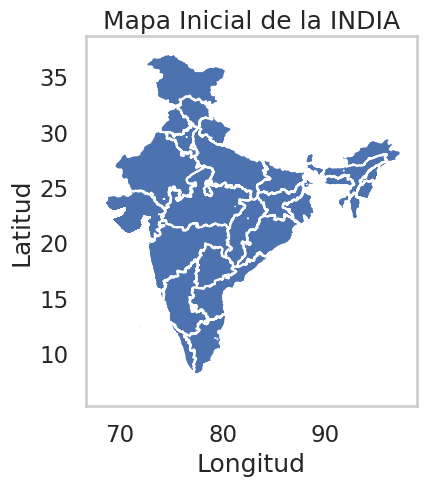

In [46]:
dfMAP.plot(missing_kwds={'color': 'lightgrey'})
plt.title("Mapa Inicial de la INDIA")
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

- Se requiere superponer las etiquetas de los estados de la India en el MAPA

In [47]:
#Se importa el ajuste para hacer la posición de las etiquetas
from adjustText import adjust_text

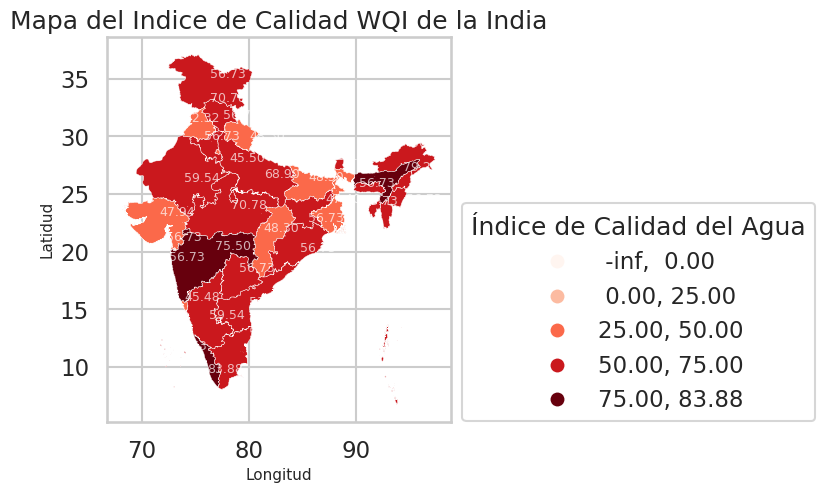

In [48]:
#Se verifica los valores NULOS; en caso de que existan se cambian por el promedio
#Se toma la ruta corta (La imputación de valores nulos pueder ser mejor tratada)
dfMAP['WQI']= dfMAP['WQI'].fillna(dfMAP['WQI'].median())

##Configuración de Estilos para ser usados en la impresión con seaborn
sns.set_context("talk") #Puede ser cualquiera
sns.set_style("whitegrid") #Puede ser cualquiera de la biblioteca de estilos de seaborn

#Se ajusta el mapa
fig, ax = plt.subplots(figsize = (5, 5))
#Dibujar el mapa
dfMAP.plot(column='WQI', cmap='Reds', ax=ax, scheme='userdefined',
    classification_kwds={'bins': [0, 25, 50, 75]}, legend=True, linewidth=0.3)

##Ajustar la leyenda
leg = ax.get_legend()
leg.set_title('Índice de Calidad del Agua')
leg.set_bbox_to_anchor((1,0.6))

## Se agregan las etiquetas sin superposición (tener cuidado con el tamaño del PLOT)
textos = []
for _, row in dfMAP.iterrows():
    if not np.isnan(row['WQI']):
        centroide = row.geometry.centroid
        texto = ax.annotate(f"{row['WQI']:.2f}", xy=(centroide.x, centroide.y), fontsize = 9, color='white', alpha =0.7)
        textos.append(texto)

#Ajustar texto de etiquetas
adjust_text(textos, ax=ax, force_points=(0.2, 0.2))

### CARPINTERIA
ax.set_title("Mapa del Indice de Calidad WQI de la India")
ax.set_xlabel("Longitud", fontsize=11)
ax.set_ylabel("Latidud", fontsize=11)
plt.show()

### **Histograma de WQI por estado**

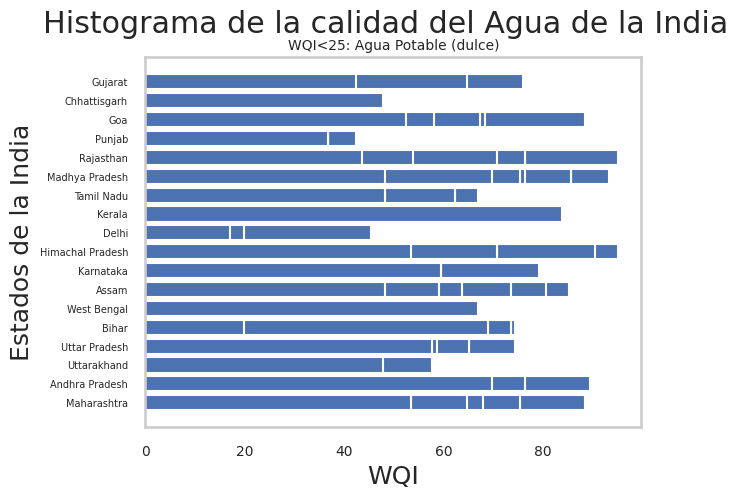

In [49]:
df06.createOrReplaceTempView("df06_sql")
#Se seleccionan los nombres de los estados
Estados = spark09.sql("Select STATE from df06_sql")
Estados = Estados.rdd.map(lambda row:row.STATE).collect()

## Seleccionamos los valoers de WQI
wqi = spark09.sql("Select WQI from df06_sql")
wqi = wqi.rdd.map(lambda row:row.WQI).collect()

## Se grafica el histograma
plt.barh(Estados, wqi)
plt.suptitle("Histograma de la calidad del Agua de la India")
plt.title("WQI<25: Agua Potable (dulce)", fontsize = 10)
plt.xlabel("WQI")
plt.ylabel("Estados de la India")
plt.xticks(fontsize=10)
plt.yticks(fontsize=7)

plt.grid()
plt.show()

### **Creación de Modelo: Calidad de Agua en la India**

     - Se requiere predecir el parámetro WQI.
     - Se crea un DF en pandas, un vector para manipular a través de numpy las columnas de calidad: "Rangos de calidad".
     - Se importa Scikit-Learn, para separar los datos (Entrenamiento y Prueba).
     - Se importa Keras Sequential Layers Dense.
     - Se inicializa el modelo, y se añaden las capas.
     - Se compila el modelo con el optimizador ADAM junto con la función de perdida de error cuadrático.
     - Se realiza el experimento sobre los datos de entrenamiento.
     - Se realiza la evaluación sobre los datos de prueba; para la selección del modelo.

In [50]:
#- Se requiere predecir el WQI
# Se crea una dataframe en pandas, un vector para manipular a través de numpy las columnas de calidad: "Rangos de calidad"

dfcalidad = df06.select('qrPH','qrDO','qrCOND','qrBOD','qrNN','qrFecal')
dfPredecir = df06.select('WQI')

dfcalidad.show(5)
dfPredecir.show(5)


+----+----+------+-----+----+-------+
|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFecal|
+----+----+------+-----+----+-------+
| 100| 100|     0|    0| 100|    100|
| 100| 100|    40|    0| 100|     60|
| 100|  40|     0|    0| 100|     60|
| 100|  40|     0|    0| 100|     60|
| 100|  40|    40|    0| 100|     80|
+----+----+------+-----+----+-------+
only showing top 5 rows

+-----+
|  WQI|
+-----+
| 75.5|
|73.62|
| 47.4|
| 47.4|
|62.38|
+-----+
only showing top 5 rows



In [51]:
# - Se crea un dataframe en pandas, un vector para manipular a traves de numpy las colimnas de calidad?: "Rangos de Calidad"
# - Se impora Scikit-Larin, para separar los datos (Entrenamiento: 80% y Prueba: 20%)

from sklearn.model_selection import train_test_split

dataTrain, dataTest, predTrain, predTest = train_test_split(dfcalidad.toPandas(), dfPredecir.toPandas(), test_size=0.2, random_state=1)

In [52]:
print(f"Cantidad de datos totales: {df06.count(), len(df06.columns)}")
print(f"Cantidad de datos Entrenamiento: {dataTrain.shape}")
print(f"Cantidad de datos Prueba: {dataTest.shape}")
print(f"Cantidad de datos Predicción del Entrenamiento: {predTrain.shape}")
print(f"Cantidad de datos Predicción de Prueba: {predTest.shape}")

Cantidad de datos totales: (534, 24)
Cantidad de datos Entrenamiento: (427, 6)
Cantidad de datos Prueba: (107, 6)
Cantidad de datos Predicción del Entrenamiento: (427, 1)
Cantidad de datos Predicción de Prueba: (107, 1)


In [53]:
## Se importa la instancia TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense

2025-10-17 22:11:22.750267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-17 22:11:22.750729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 22:11:22.822458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 22:11:24.592430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [169]:
#Se ajustan las variables: El ajuste es de forma estandar. Se requiere un estudio profundo sobre el ajuste de los parámetros, para que sea 
#el modelo mucho más eficiente. El estudio a continuación es una guia para abordar modelos de Tensores en Predicción de calidad de agua, como guía 
#metodológica académica

epocas = 200
lote = 81 #Mejor que sea impar, ya que si es par no determina la paridad
# Se inicializa el modelo con las capas
modelo01 = Sequential()
modelo01.add(Dense(350, input_dim=6, activation = 'relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(350, activation='relu'))
modelo01.add(Dense(1, activation='linear'))

/home/estudiante/miniconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [170]:
# Para optimizar el modelo se usa el optimizador ADAM
# La compilación se ajusta a la pérdidad del error cuadrático
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo01.compile(loss='mean_squared_error', optimizer = 'Adam', metrics = ['mse'])

In [171]:
modelo01.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 350)            │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 350)            │       122,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [172]:
ejecutarK= modelo01.fit(dataTrain,predTrain, epochs = epocas, batch_size=lote)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1560.7089 - mse: 1560.7089  
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 137.6992 - mse: 137.6992
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 64.0696 - mse: 64.0696 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.9813 - mse: 25.9813 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.2568 - mse: 11.2568 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2623 - mse: 7.2623 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5622 - mse: 5.5622 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4596 - mse: 3.4596 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2621 - mse: 2.2621
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1536 - mse: 1.1536 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5287 - mse: 0.5287  
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3264 - mse: 0.3264 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━

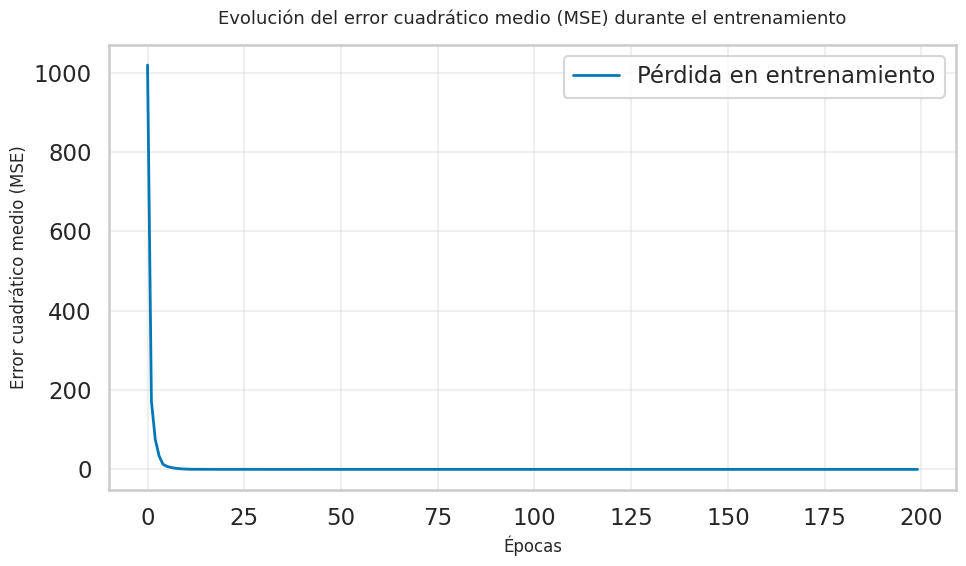

In [173]:
plt.figure(figsize=(10,6))
plt.plot(ejecutarK.history['loss'], label='Pérdida en entrenamiento', color='#0077b6', linewidth=2)

plt.title('Evolución del error cuadrático medio (MSE) durante el entrenamiento', fontsize=13, pad=15)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Error cuadrático medio (MSE)', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [174]:
### Se requiere predecir sobre los datos del entrenamiento
predModelo01_Train = modelo01.predict(dataTrain)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


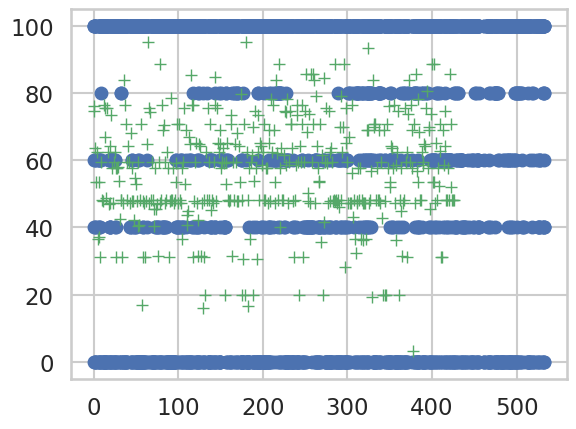

In [175]:
### Se pinta la prediccion
plt.plot(dataTrain,'bo', predModelo01_Train, 'g+')
plt.show()


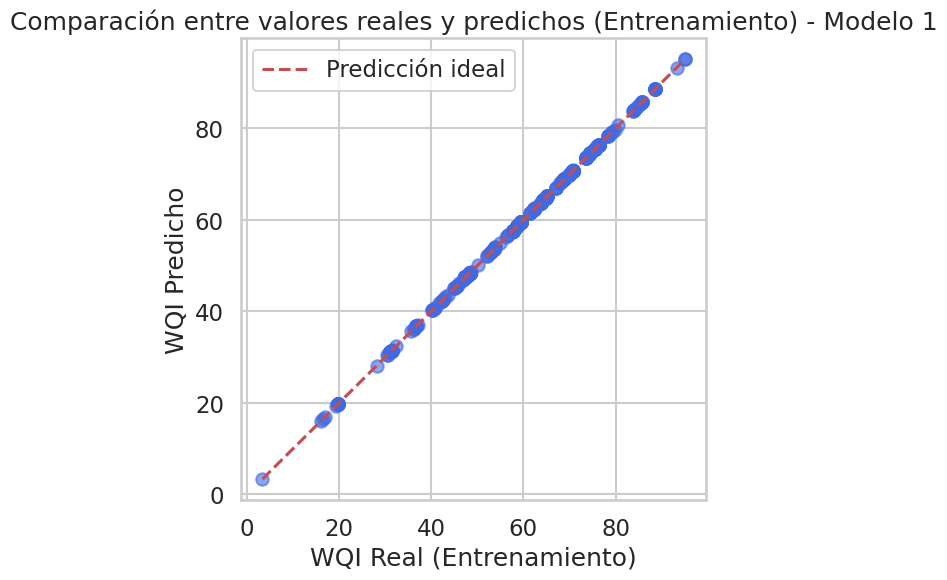

In [199]:
### Se comparan los valores reales con los valores predichos del modelo
### Los puntos cercanos a la línea roja indican buenas predicciones

plt.figure(figsize=(6,6))
plt.scatter(predTrain, predModelo01_Train, c='royalblue', alpha=0.6)
plt.plot([predTrain.min(), predTrain.max()],
         [predTrain.min(), predTrain.max()],
         'r--', label='Predicción ideal')
plt.xlabel("WQI Real (Entrenamiento)")
plt.ylabel("WQI Predicho")
plt.title("Comparación entre valores reales y predichos (Entrenamiento) - Modelo 1")
plt.legend()
plt.grid(True)
plt.show()

In [195]:
#evaluar el rendimiento del modelo entrenado, y que qué tan bien el modelo ajusta los datos de entrenamiento.
resultado = modelo01.evaluate(dataTrain, predTrain)
print(f"Error cuadrático medio (MSE): {resultado[0]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9557e-04 - mse: 2.9557e-04 
Error cuadrático medio (MSE): 0.0003


#### **Modelo 2**

In [187]:
# Ajuste del modelo

#Para el cambio de las variables se tuvo en cuenta la sugerencia de clase, que el entrenamiento puede ser demasiado para el tamaño del dataset
#Por esto se decidió intentar con menos capas
epocas = 200
lote = 55
# Se inicializa el modelo con las capas
modelo02 = Sequential()
modelo02.add(Dense(128, input_dim=6, activation='relu'))
modelo02.add(Dense(64, activation='relu'))
modelo02.add(Dense(16, activation='relu'))
modelo02.add(Dense(1, activation='linear'))

keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo02.compile(loss='mean_squared_error', optimizer = 'Adam', metrics = ['mse'])

/home/estudiante/miniconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [188]:
modelo02.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,209 (39.88 KB)

 Trainable params: 10,209 (39.88 KB)

 Non-trainable params: 0 (0.00 B)

In [189]:
#Se le agrega validation_split para revisar la périda en validación
historial = modelo02.fit(dataTrain,predTrain, epochs = epocas, batch_size=lote, validation_split=0.2,
    verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1628.7012 - mse: 1628.7012 - val_loss: 109.4936 - val_mse: 109.4936
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 183.0846 - mse: 183.0846 - val_loss: 206.4313 - val_mse: 206.4313
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 138.1425 - mse: 138.1425 - val_loss: 93.7032 - val_mse: 93.7032
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 85.4467 - mse: 85.4467 - val_loss: 68.6695 - val_mse: 68.6695
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 45.6043 - mse: 45.6043 - val_loss: 38.4266 - val_mse: 38.4266
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.2482 - mse: 27.2482 - val_loss: 15.7623 - val_mse: 15.7623
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.9279 - mse: 14.9279 - val_loss: 9.0612 - val_mse: 9.0612
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6963 - mse: 7.6963 - val_loss: 6.9580 - val_mse: 6.9580
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━

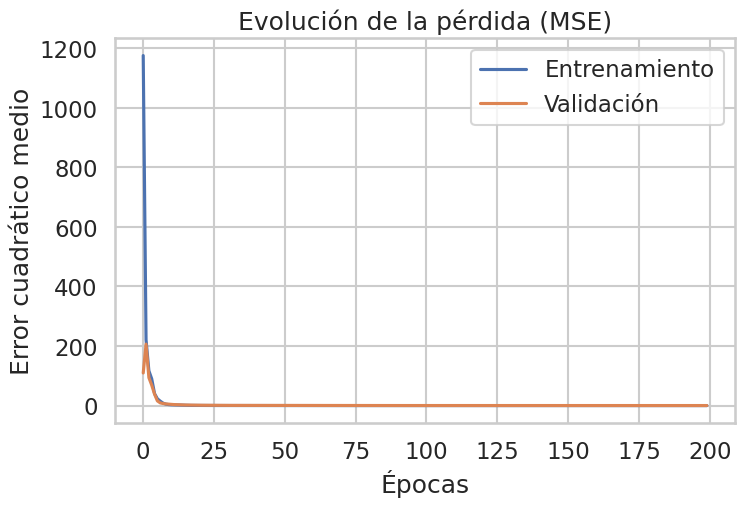

In [190]:
plt.figure(figsize=(8,5))
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
### Se requiere predecir sobre los datos del entrenamiento
predModelo02_Train = modelo02.predict(dataTrain)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


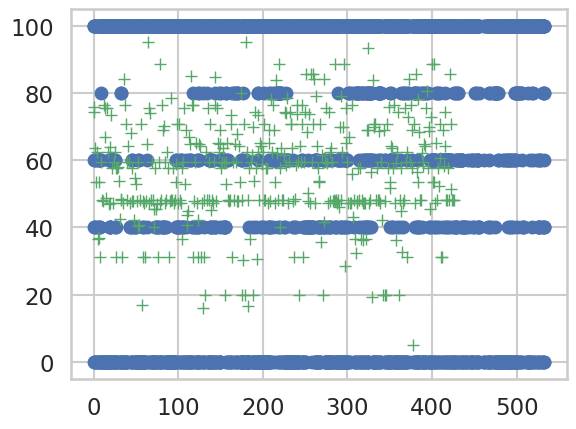

In [192]:
### Se pinta la prediccion
plt.plot(dataTrain,'bo', predModelo02_Train, 'g+')
plt.show()

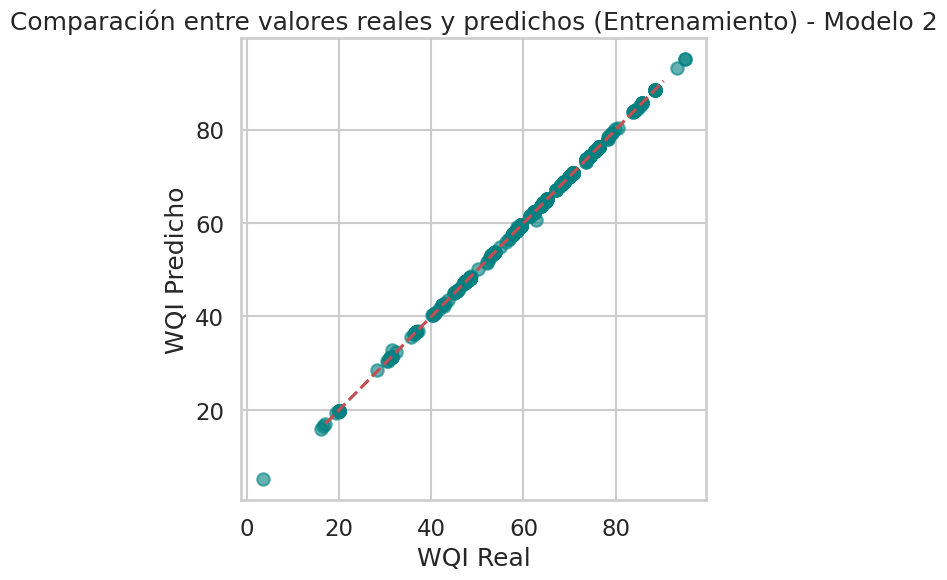

In [200]:
### Se comparan los valores reales con los valores predichos del modelo
### Los puntos cercanos a la línea roja indican buenas predicciones

plt.figure(figsize=(6,6))
plt.scatter(predTrain, predModelo02_Train, c='teal', alpha=0.6)
plt.plot([predTest.min(), predTest.max()], [predTest.min(), predTest.max()], 'r--')
plt.xlabel("WQI Real")
plt.ylabel("WQI Predicho")
plt.title("Comparación entre valores reales y predichos (Entrenamiento) - Modelo 2")
plt.grid(True)
plt.show()

In [196]:
resultado = modelo02.evaluate(dataTrain, predTrain)
print(f"Error cuadrático medio (MSE): {resultado[0]:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - mse: 0.0101 
Error cuadrático medio (MSE): 0.0305


### **Comparación entre modelos**

In [202]:
# Se realizó el entrenamiento de 2 modelos:
# El modelo 1: 3 capas de 350 neuronas
# El modelo 2: 3 capas de 128, 64 y 16 neuronas

# Al evaluar la precisión viendo las gráfocas de "comparación entre valores reales y predichos (Entrenamiento)" ambas aciertan bastante a los datos 
# entrendos, sin embargo, se nota como el modelo 2 tiene una leve desviación mayor comparado con el modelo 1.
# Adicionalmente, al comparar el MSE de cada modelo, el modelo 1 obtuvo 0.0003, mientras que el modelo 2 obtuvo 0.0305. Esto es 100 veces más que el 
# modelo 1. Esto indica que el modelo 1 tuvo un ajuste mucho más preciso durante el entrenamiento.

# Conclusiones:
# El Modelo 1 es mucho más grande, por lo que tiene mayor capacidad de aprendizaje y puede ajustarse mejor a los datos de entrenamiento.
# El Modelo 2 es más liviano, lo que busca reducir sobreajuste y mejorar generalización, aunque pierde perder precisión.

# Recomendaciones:
# Al evaluar el modelo solo en el entrenamiento, se concluye que un modelo grande como el modelo 1 es el más apropiado.